# Deep Dream


In [1]:
from pathlib import Path
from datetime import datetime as dt

import cv2
import scipy
import numpy as np
import matplotlib.pyplot as plt

from keras import applications
from keras import backend as K
import tensorflow as tf

from skimage.io import imread, imsave
from skimage import img_as_float, img_as_ubyte
from skimage.transform import pyramid_gaussian, rescale

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
def preprocess(img):
    img = img.copy()
    
    img = img.astype("float32")
    
    img = img[:, :, ::-1]
    
    img[:, :, 0] -= 103.939
    img[:, :, 1] -= 116.779
    img[:, :, 2] -= 123.68 
    
    return img

def postprocess(img):
    img = img.copy()
    
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68 

    return np.clip(img[:, :, ::-1], 0, 255).astype('uint8')

def imshow(imgs, titles=None, n_cols=5, figsize=(10, 10)):
    if len(imgs) == 1:
        plt.figure(figsize=figsize)
        plt.imshow(imgs[0])
        plt.axis('off')
        return
    
    n_cols = min(len(imgs), n_cols)
    n_rows = (len(imgs) // n_cols)
    
    if len(imgs) > n_cols * n_rows:
        n_rows += 1
    
    f, axs = plt.subplots(n_rows, n_cols, figsize=figsize)
    titles = titles if titles is not None else [""] * len(imgs)
    
    for idx, (img, title) in enumerate(zip(imgs, titles)):
        if n_rows == 1:
            ax = axs[idx % n_cols]
        elif n_cols == 1:
            ax = axs[idx % n_rows]
        else:
            ax = axs[idx // n_cols, idx % n_cols]
        
        ax.imshow(img)
        ax.set_title(title)
    
    for ax in axs.flatten():
        ax.set_axis_off()

## Définition du modèle (VGG16)

In [3]:
model = applications.VGG16(include_top=False, weights="imagenet")

dream = model.input

layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

## Définition de la fonction de coût à maximiser et de la procédure d'optimisation

In [4]:
def get_layer_loss_and_grads_function(layer_weights, decay):
    loss = K.variable(0.)

    for layer_name, weight in layer_weights.items():
        layer_output = layer_dict[layer_name].output
        
        # scaling = K.prod(K.cast(K.shape(layer_output), 'float32'))
        loss += K.sum(K.square(layer_output)) # / scaling
        
#         scaling = K.prod(K.cast(K.shape(layer_output), 'float32'))
#         loss = loss + (weight * K.sum(K.square(layer_output[:, 2: -2, 2: -2, :])) / scaling)

    # scaling = K.prod(K.cast(K.shape(dream), 'float32'))
    loss -= decay * K.sum(K.square(dream)) # / scaling
    loss -= tf.image.total_variation(dream)[0]
    
    grads = K.gradients(loss, dream)[0]
    grads /= K.maximum(K.mean(K.abs(grads)), K.epsilon())
    
    return K.function([dream], [loss, grads])

def optimize_input(img, layer_weights, iterations, step, decay):
    loss_and_grads_function = get_layer_loss_and_grads_function(layer_weights, decay)
    
    for i in range(iterations):
        loss_value, grads_value = loss_and_grads_function([[img]])

        current_step = step - (i * (step / iterations))
        img += current_step * grads_value[0]

        print(f"loss value at {i} = {loss_value:.2f}")
        
    return img

## Optimisation directe

In [5]:
iterations = 20
step = 1.
decay = 0.005

layer_weights = {
    'block5_conv1': 0.001,
    'block5_conv2': 0.001,
}

img = imread("test.jpg")

img = preprocess(img)
img = optimize_input(img, layer_weights, iterations, step, decay)
img = postprocess(img)

loss value at 0 = 3508693504.00
loss value at 1 = 6675781120.00
loss value at 2 = 11189746688.00
loss value at 3 = 17222453248.00
loss value at 4 = 24510525440.00
loss value at 5 = 33718228992.00
loss value at 6 = 44677509120.00
loss value at 7 = 57541554176.00
loss value at 8 = 73834815488.00
loss value at 9 = 90726096896.00
loss value at 10 = 111549194240.00
loss value at 11 = 133328879616.00
loss value at 12 = 156506603520.00
loss value at 13 = 179757449216.00
loss value at 14 = 203237605376.00
loss value at 15 = 225806450688.00
loss value at 16 = 246002057216.00
loss value at 17 = 263483670528.00
loss value at 18 = 277292777472.00
loss value at 19 = 286827085824.00


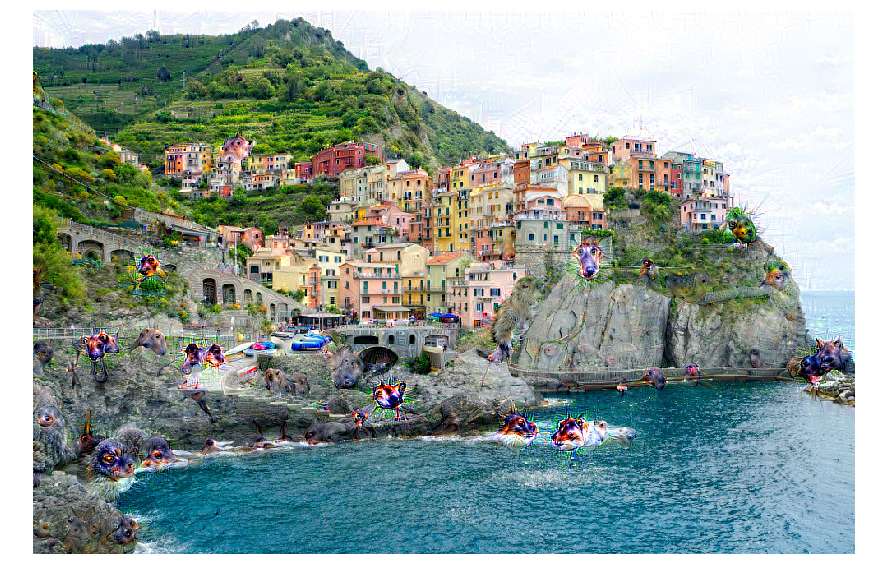

In [6]:
imshow([img], figsize=(20, 10))

## Optimisations successives de l'image à différentes échelles

In [7]:
octave = 5
scale = 1.5
iterations = 10

step = 2
decay = 0.005

layer_weights = {
    'block5_conv1': 0.001,
    'block5_conv2': 0.001,
}

original_img = imread("test.jpg")

pyramid = list(pyramid_gaussian(original_img, downscale=scale, max_layer=octave, multichannel=True))[::-1]

current = None

np.random.seed(0)

for i, img in enumerate(pyramid):
    print(f"#{i} {img.shape}")
    
    if current is None:
        pp = preprocess(img_as_ubyte(img))
        current = optimize_input(pp, layer_weights, 2, step, decay)
    
    else:
        h, w = img.shape[0:2]
        ph, pw = current.shape[0:2]
        
        rescaled = rescale(current, scale=(h/ph, w/pw), order=5)
        combined = 0.6 * img_as_float(img) + 0.4 * img_as_float(rescaled)
        
        pp = preprocess(img_as_ubyte(combined))
        current = optimize_input(pp, layer_weights, iterations, step, decay)
    
    current = postprocess(current)

#0 (88, 132, 3)
loss value at 0 = 86248352.00
loss value at 1 = 201611696.00
#1 (132, 198, 3)
loss value at 0 = 170256496.00
loss value at 1 = 393486624.00
loss value at 2 = 768659456.00
loss value at 3 = 1243804416.00
loss value at 4 = 1818751232.00
loss value at 5 = 2470567424.00
loss value at 6 = 3190241024.00
loss value at 7 = 3828572928.00
loss value at 8 = 4391089152.00
loss value at 9 = 4815727104.00
#2 (197, 297, 3)
loss value at 0 = 527421088.00
loss value at 1 = 1341492096.00
loss value at 2 = 2600032512.00
loss value at 3 = 4156484608.00
loss value at 4 = 5872061440.00
loss value at 5 = 7902447104.00
loss value at 6 = 9822998528.00
loss value at 7 = 11834671104.00
loss value at 8 = 13653968896.00
loss value at 9 = 15076270080.00
#3 (295, 445, 3)
loss value at 0 = 1014298176.00
loss value at 1 = 3289643008.00
loss value at 2 = 6852145152.00
loss value at 3 = 11801453568.00
loss value at 4 = 18439190528.00
loss value at 5 = 25887195136.00
loss value at 6 = 34086014976.00
loss 

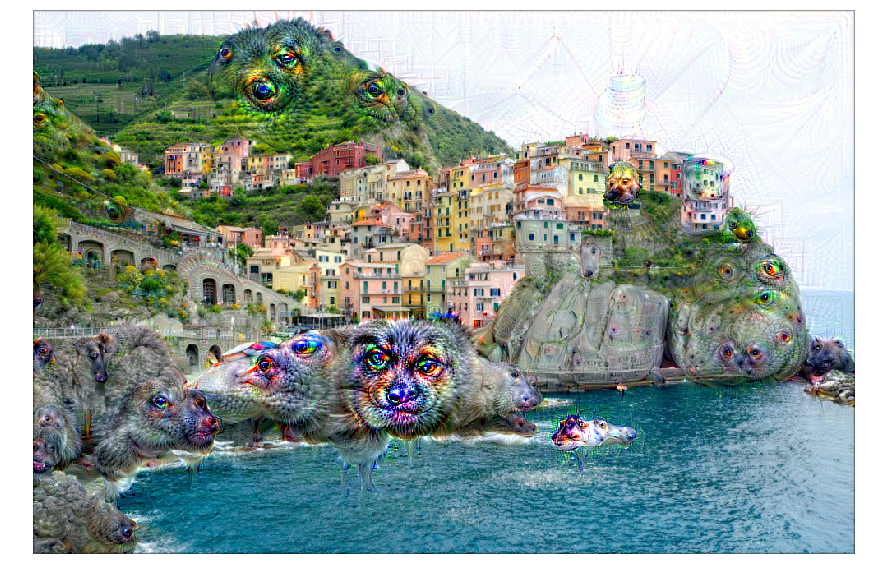

In [8]:
imshow([current], figsize=(20, 10))